# Twitter Sentiment Analysis

In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
# `%matplotlib inline` is only used in Jupyter Notebooks, remove if running outside Jupyter
# Ensure plots are displayed inline in Jupyter Notebook
%matplotlib inline  

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# TensorFlow / Keras (Updated)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Ensure nltk resources are downloaded
nltk.download('stopwords')

# Word2Vec (gensim updated usage)
import gensim
from gensim.models import Word2Vec

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log (Keep the logging consistent)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Verify all important resources are downloaded for nltk and gensim
nltk.download('punkt')  # Required for tokenization


2024-12-26 22:18:04.136956: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-26 22:18:04.261340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735231684.301922    6833 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735231684.314996    6833 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-26 22:18:04.431500: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

True

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jaeyesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [3]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [4]:

df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [5]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [6]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [7]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 177 ms, sys: 6.71 ms, total: 184 ms
Wall time: 183 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

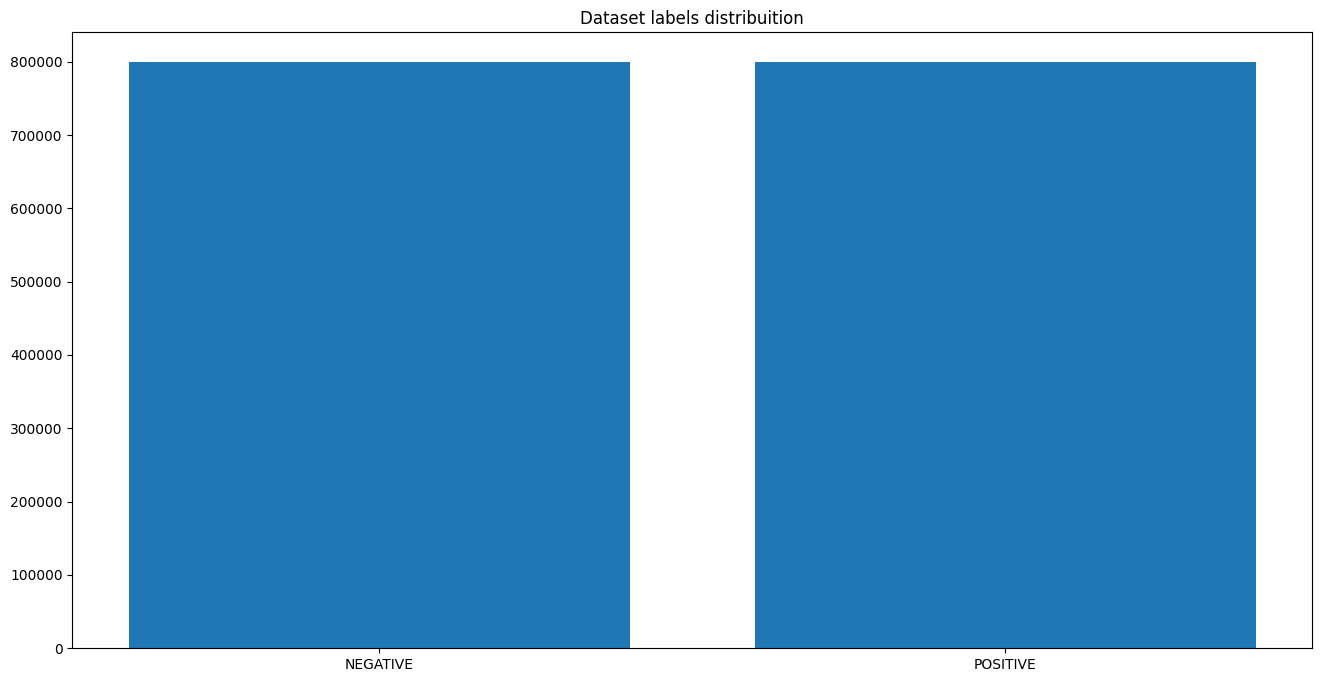

In [9]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [10]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [11]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [12]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 28.9 s, sys: 70.5 ms, total: 29 s
Wall time: 29 s


### Split train and test

In [13]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [14]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.37 s, sys: 236 ms, total: 2.61 s
Wall time: 2.6 s


In [15]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)


2024-12-26 22:18:41,249 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2024-12-26T22:18:41.249315', 'gensim': '4.3.3', 'python': '3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]', 'platform': 'Linux-6.8.0-49-generic-x86_64-with-glibc2.35', 'event': 'created'}


In [16]:
w2v_model.build_vocab(documents)

2024-12-26 22:18:41,306 : INFO : collecting all words and their counts
2024-12-26 22:18:41,308 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-12-26 22:18:41,319 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2024-12-26 22:18:41,330 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2024-12-26 22:18:41,341 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2024-12-26 22:18:41,352 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2024-12-26 22:18:41,364 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2024-12-26 22:18:41,376 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2024-12-26 22:18:41,389 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2024-12-26 22:18:41,402 : INFO : PROGRESS: at s

In [17]:
words = w2v_model.wv.index_to_key
vocab_size = len(words)
print("Vocab size:", vocab_size)


Vocab size: 30369


In [18]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2024-12-26 22:18:43,698 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2024-12-26T22:18:43.698426', 'gensim': '4.3.3', 'python': '3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]', 'platform': 'Linux-6.8.0-49-generic-x86_64-with-glibc2.35', 'event': 'train'}
2024-12-26 22:18:44,714 : INFO : EPOCH 0 - PROGRESS: at 34.68% examples, 2832777 words/s, in_qsize 15, out_qsize 1
2024-12-26 22:18:45,716 : INFO : EPOCH 0 - PROGRESS: at 71.57% examples, 2931989 words/s, in_qsize 14, out_qsize 5
2024-12-26 22:18:46,465 : INFO : EPOCH 0: training on 9227204 raw words (8222794 effective words) took 2.8s, 2981967 effective words/s
2024-12-26 22:18:47,474 : INFO : EPOCH 1 - PROGRESS: at 35.65% examples, 2926272 words/s, in_qsize 15, out_qsize 0
2024-12-26 22:18:48,481 : INFO : EPOCH 1 - PROGRESS: at 72.75% examples, 2980695 words/s, in_qsize 12, out_qsiz

CPU times: user 8min 58s, sys: 2.15 s, total: 9min 1s
Wall time: 1min 30s


(263127080, 295270528)

In [19]:
similar_words = w2v_model.wv.most_similar("love")
print(similar_words)


[('luv', 0.5723538994789124), ('loves', 0.5590510964393616), ('loved', 0.5329751968383789), ('amazing', 0.5068702697753906), ('adore', 0.501704752445221), ('looove', 0.4970366656780243), ('lovee', 0.46299248933792114), ('awesome', 0.45485374331474304), ('loooove', 0.4504445493221283), ('loove', 0.4311593174934387)]


### Tokenize Text

In [20]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 12 s, sys: 86.6 ms, total: 12.1 s
Wall time: 12 s


In [21]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 18 s, sys: 338 ms, total: 18.3 s
Wall time: 18.3 s


### Label Encoder 

In [22]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [23]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [24]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [25]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [26]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [27]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

/home/jaeyesh/PycharmProjects/SA/.venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1735231846.917915    6833 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4280 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


### Build Model

In [28]:
# Define the model
model = Sequential()
model.add(embedding_layer)  # Ensure embedding_layer is defined earlier in the script
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    87,125,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,125,700 (332.36 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 87,125,700 (332.36 MB)

### Compile model

In [29]:
# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

### Callbacks

In [30]:
# Define callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
    EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)  # Updated monitor
]

### Train

In [31]:
%%time
# Train the model
history = model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    callbacks=callbacks  # Added callbacks
)


Epoch 1/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 263s 232ms/step - accuracy: 0.7279 - loss: 0.5344 - val_accuracy: 0.7773 - val_loss: 0.4692 - learning_rate: 0.0010
Epoch 2/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 263s 233ms/step - accuracy: 0.7606 - loss: 0.4886 - val_accuracy: 0.7825 - val_loss: 0.4605 - learning_rate: 0.0010
Epoch 3/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 263s 234ms/step - accuracy: 0.7675 - loss: 0.4783 - val_accuracy: 0.7853 - val_loss: 0.4565 - learning_rate: 0.0010
Epoch 4/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 264s 235ms/step - accuracy: 0.7711 - loss: 0.4737 - val_accuracy: 0.7865 - val_loss: 0.4525 - learning_rate: 0.0010
Epoch 5/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 265s 236ms/step - accuracy: 0.7727 - loss: 0.4706 - val_accuracy: 0.7881 - val_loss: 0.4507 - learning_rate: 0.0010
Epoch 6/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 238s 212ms/step - accuracy: 0.7733 - loss: 0.4692 - val_accuracy: 0.7888 - val_loss: 0.4488 - learning_rate: 0.0010
Epoch 7/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 219s 195ms/step -

### Evaluate

In [32]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1)
print("\nACCURACY:", score[1])
print("LOSS:", score[0])


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.7907 - loss: 0.4453

ACCURACY: 0.7904062271118164
LOSS: 0.44641396403312683
CPU times: user 28.5 s, sys: 1.48 s, total: 30 s
Wall time: 27.6 s


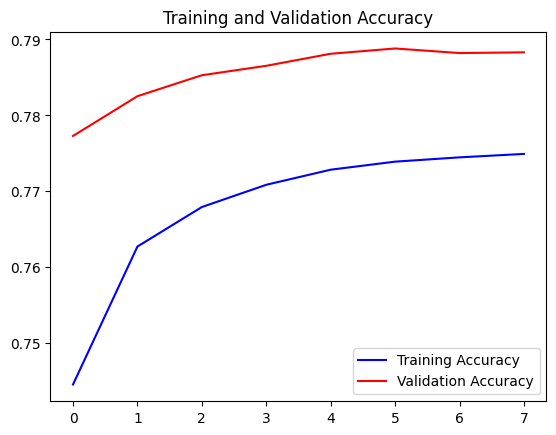

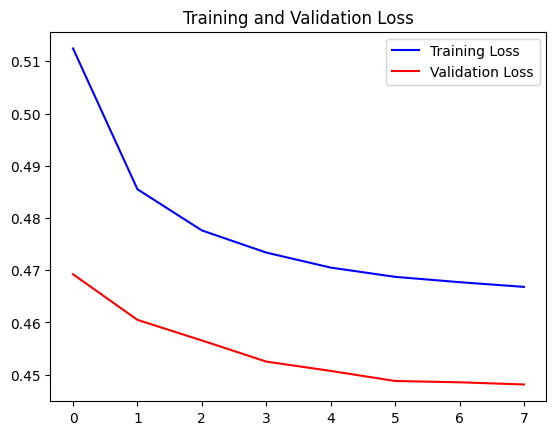

In [33]:
acc = history.history.get('accuracy', history.history.get('acc'))  # Handle older versions
val_acc = history.history.get('val_accuracy', history.history.get('val_acc'))  # Handle older versions
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot training and validation accuracy
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

# Plot training and validation loss
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


### Predict

In [34]:
def decode_sentiment(score, include_neutral=True):
    """
    Decodes the sentiment based on the score and thresholds.

    Args:
        score (float): The sentiment score (typically between 0 and 1).
        include_neutral (bool): Whether to include the 'neutral' sentiment category.

    Returns:
        str: The sentiment label ('NEGATIVE', 'NEUTRAL', or 'POSITIVE').
    """
    if include_neutral:
        if score <= SENTIMENT_THRESHOLDS[0]:
            return NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            return POSITIVE
        else:
            return NEUTRAL
    else:
        return NEGATIVE if score < 0.5 else POSITIVE


In [35]:
def predict(text, include_neutral=True):
    """
    Predicts the sentiment of the given text.

    Args:
        text (str): The input text to analyze.
        include_neutral (bool): Whether to include the 'neutral' sentiment category.

    Returns:
        dict: A dictionary containing the sentiment label, score, and elapsed time.
    """
    start_at = time.time()
    
    # Tokenize and pad text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    
    # Predict sentiment score
    score = model.predict(x_test, verbose=0)[0]  # Added `verbose=0` for clean output
    
    # Decode sentiment label
    label = decode_sentiment(score, include_neutral=include_neutral)

    # Return results
    return {
        "label": label,
        "score": float(score),
        "elapsed_time": time.time() - start_at
    }


In [36]:
predict("I love the music")

/tmp/ipykernel_6833/794463065.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "score": float(score),


{'label': 'POSITIVE',
 'score': 0.9700713753700256,
 'elapsed_time': 0.17755937576293945}

In [37]:
predict("I hate the rain")

/tmp/ipykernel_6833/794463065.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "score": float(score),


{'label': 'NEGATIVE',
 'score': 0.00839158333837986,
 'elapsed_time': 0.0899348258972168}

In [38]:
predict("i don't know what i'm doing")

/tmp/ipykernel_6833/794463065.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "score": float(score),


{'label': 'NEGATIVE',
 'score': 0.2946835458278656,
 'elapsed_time': 0.11291289329528809}

### Confusion Matrix

In [44]:
%%time
y_test_1d = list(df_test.target)  # No change, keeping the target as is

# Get predictions
scores = model.predict(x_test, verbose=1, batch_size=250)

# Decode sentiment for each score and store in y_pred_1d
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]


1280/1280 ━━━━━━━━━━━━━━━━━━━━ 76s 59ms/step
CPU times: user 1min 27s, sys: 5.01 s, total: 1min 32s
Wall time: 1min 17s


In [45]:
scores = model.predict(x_test, verbose=1, batch_size=256)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 72s 58ms/step


In [46]:

def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Args:
        cm (numpy.ndarray): Confusion matrix to be plotted.
        classes (list): List of class labels.
        normalize (bool): Whether to normalize the confusion matrix.
        title (str): Title for the confusion matrix plot.
        cmap (matplotlib.colors.ListedColormap): Colormap to use for the plot.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=18)
    plt.yticks(tick_marks, classes, fontsize=18)

    fmt = '.2f' if normalize else 'd'  # Display float if normalized, otherwise integers
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)
    plt.tight_layout()


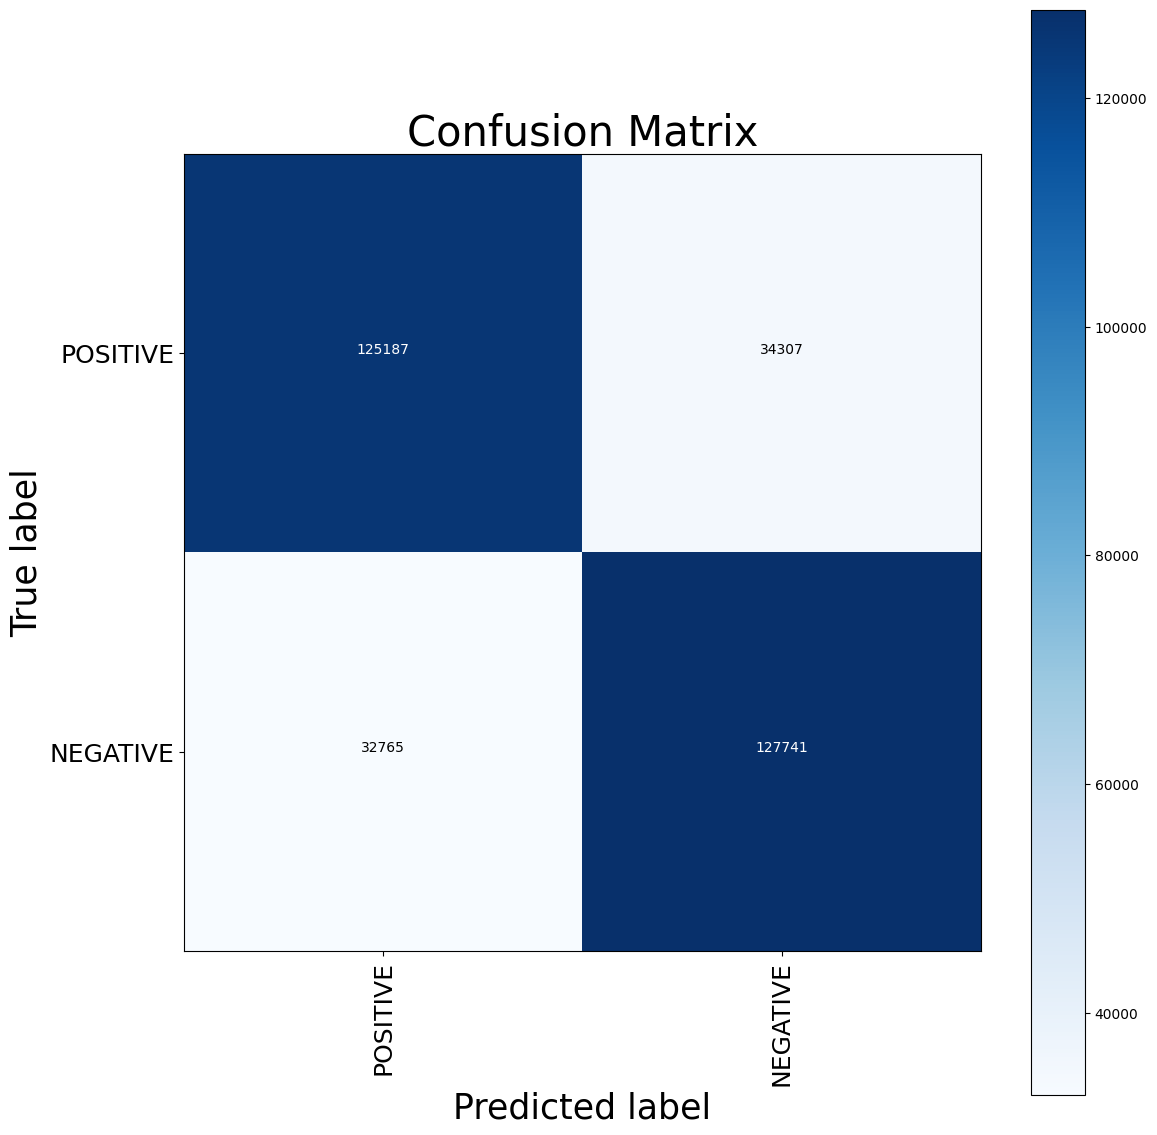

CPU times: user 789 ms, sys: 310 ms, total: 1.1 s
Wall time: 764 ms


In [47]:
%%time

# Generate the confusion matrix
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)

# Set up the figure size
plt.figure(figsize=(12, 12))

# Plot the confusion matrix with class labels from df_train
plot_confusion_matrix(cnf_matrix, 
                      classes=[str(label) for label in df_train.target.unique()],
                      title="Confusion Matrix", 
                      normalize=False)  # Set normalize=True if needed

# Display the plot
plt.show()


### Classification Report

In [48]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.78      0.79    159494
    POSITIVE       0.79      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



### Accuracy Score

In [49]:
accuracy_score(y_test_1d, y_pred_1d)

0.7904

### Save model

In [50]:

# Save the Keras model (full model including architecture, weights, and optimizer state)
model.save(KERAS_MODEL)

# Save the Word2Vec model (Gensim)
w2v_model.save(WORD2VEC_MODEL)

# Save the tokenizer using pickle (ensure compatibility with pickle protocol)
with open(TOKENIZER_MODEL, 'wb') as f:
    pickle.dump(tokenizer, f, protocol=0)

# Save the encoder using pickle
with open(ENCODER_MODEL, 'wb') as f:
    pickle.dump(encoder, f, protocol=0)


2024-12-26 23:04:23,115 : WARNING : You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2024-12-26 23:04:23,572 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'model.w2v', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2024-12-26T23:04:23.572762', 'gensim': '4.3.3', 'python': '3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]', 'platform': 'Linux-6.8.0-49-generic-x86_64-with-glibc2.35', 'event': 'saving'}
2024-12-26 23:04:23,573 : INFO : not storing attribute cum_table
2024-12-26 23:04:23,653 : INFO : saved model.w2v
